In [119]:
import argparse
import os
from kabuki.analyze import gelman_rubin
import pandas
import hddm
import glob
import re
import pickle as pkl

path = '/home/gdholla1/projects/bias/data/hddm_fits'

# SELECT MASK


def get_model(model, hemisphere):
    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior_and_single_trial_estimates.pandas')

    # Prepare data
    data = df
    data['response'] = data['correct']
    data['rt'] = data['rt'] / 1000.
    data = data[(data.rt > .2) & (data.rt < 1.5)]
    data = data[~data.rt.isnull()]
    data['cue_coding'] = data.cue_validity.map({'valid':1, 'neutral':0, 'invalid':-1})

    def z_link_func(x, data=data):
        return 1 / (1 + np.exp(-(x.values.ravel())))

    if model == 'drift_super':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + cue_coding + C(difficulty)*{}_stim + C(difficulty)*{}_stim + C(difficulty)*{}_stim'.format('STh_{}_A'.format(hemisphere),
                                                                                                                 'STh_{}_B'.format(hemisphere),
                                                                                                                 'STh_{}_C'.format(hemisphere),), 
                 'link_func': lambda x: x}
        
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])

    if model == 'drift_errors_super':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim + {}_stim:correct + '
                          'C(difficulty)*{}_stim + {}_stim:correct + ' 
                          'C(difficulty)*{}_stim + {}_stim:correct').format('STh_{}_A'.format(hemisphere), 'STh_{}_A'.format(hemisphere),
                                                                            'STh_{}_B'.format(hemisphere), 'STh_{}_B'.format(hemisphere),
                                                                            'STh_{}_C'.format(hemisphere), 'STh_{}_C'.format(hemisphere)), 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=True, group_only_nodes=['sv'])

    if model == 'start_point_super':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + cue_coding + C(difficulty)', 'link_func': lambda x: x}
        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])

    if model == 'all_super':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        #v_reg = {'model': ('v ~ 1 + '
                          #'C(difficulty)*{}_stim + {}_stim:correct + '
                          #'C(difficulty)*{}_stim + {}_stim:correct + ' 
                          #'C(difficulty)*{}_stim + {}_stim:correct').format('STh_{}_A'.format(hemisphere), 'STh_{}_A'.format(hemisphere),
                                                                            #'STh_{}_B'.format(hemisphere), 'STh_{}_B'.format(hemisphere),
                                                                            #'STh_{}_C'.format(hemisphere), 'STh_{}_C'.format(hemisphere)), 'link_func': lambda x: x}        
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim  + '
                          'C(difficulty)*{}_stim + ' 
                          'C(difficulty)*{}_stim').format('STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), ), 'link_func': lambda x: x}        


    if model == 'all_super_drift_bias_cue':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim  +'
                          'C(difficulty)*{}_stim + ' 
                          'C(difficulty)*{}_stim + '
                          'cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue').format('STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), 'STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), ), 'link_func': lambda x: x}        

        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])

    if model == 'all_super_drift_bias_stim':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim  +'
                          'C(difficulty)*{}_stim + ' 
                          'C(difficulty)*{}_stim + '
                          'cue_coding + cue_coding:{}_stim + cue_coding:{}_stim + cue_coding:{}_stim').format('STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), 'STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), ), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])

    if model == 'all_super_drift_bias_stim_sv_sz_p_outlier':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': ('v ~ 1 + '
                          'C(difficulty)*{}_stim  +'
                          'C(difficulty)*{}_stim + ' 
                          'C(difficulty)*{}_stim + '
                          'cue_coding + cue_coding:{}_stim + cue_coding:{}_stim + cue_coding:{}_stim').format('STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), 'STh_{}_A'.format(hemisphere), 'STh_{}_B'.format(hemisphere), 'STh_{}_C'.format(hemisphere), ), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz'], p_outlier=0.05)

    if model == 'final_super_model_startpoint':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])
    
    if model == 'final_super_model_drift':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])
        
        
    if model == 'final_super_model_startpoint_group':
        z_reg = {'model': 'z ~ 0 + cue_coding + cue_coding:{}_cue + cue_coding:{}_cue + cue_coding:{}_cue'.format('STh_{}_A'.format(hemisphere),
                                                                                                                  'STh_{}_B'.format(hemisphere),
                                                                                                                  'STh_{}_C'.format(hemisphere),), 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])


    if model == 'final_super_model_drift_group':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)*{}_stim + C(difficulty)*{}_stim +  C(difficulty)*{}_stim + cue_coding'.format('STh_{}_A'.format(hemisphere),
                                                                                                                               'STh_{}_B'.format(hemisphere),
                                                                                                                               'STh_{}_C'.format(hemisphere),), 'link_func': lambda x: x}        


        reg_descr = [z_reg, v_reg]
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=True, group_only_nodes=['sv', 'sz', 'st'])

        
        
    # NOW FIND, LOAD, AND CONCAT TRACES
    reg = re.compile('.*/traces_{model}_{hemisphere}_[0-9]+.pkl'.format(**locals()))
    fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_{hemisphere}_*.pkl'.format(**locals())) if reg.match(fn)]

    hddm_model.load_db(fns[0], db='pickle')

    for fn in fns[1:]:
        traces = pkl.load(open(fn))    
        for node in hddm_model.get_stochastics().node:
            node.trace._trace[0] = np.concatenate([traces[str(node)][0], node.trace[:]])     

    return hddm_model


# Start point

## Hierarchical

In [120]:
results = []

for hemisphere in ['L', 'R']:
    hddm_model = get_model('final_super_model_startpoint', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['z_cue_coding:STh_{hemisphere}_{segment}_cue'.format(**locals())],
                          'segment':segment,
                          'hemisphere':hemisphere})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_L_A_cue', 'z_cue_coding:STh_L_B_cue', 'z_cue_coding:STh_L_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_A_cue', 'z_cue_coding:STh_R_B_cue', 'z_cue_coding:STh_R_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


In [121]:
df = pandas.concat(results, ignore_index=True)

In [122]:
df.groupby(['hemisphere', 'segment']).apply(lambda x: (x.value > 0).mean())

hemisphere  segment
L           A          0.717083
            B          0.617617
            C          0.665900
R           A          0.748217
            B          0.203233
            C          0.941550
dtype: float64

In [123]:
sns.set_context('poster')
sns.set_style('whitegrid')

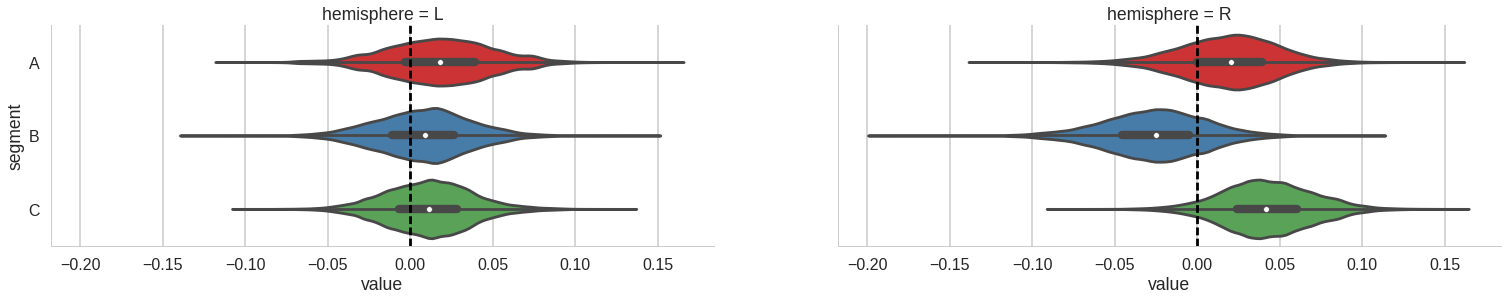

In [124]:
fac = sns.FacetGrid(df, col='hemisphere')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')


fac.fig.set_size_inches(25, 6)

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')

## Start point Group model

Adding these covariates:
['z_cue_coding', 'z_cue_coding:STh_R_A_cue', 'z_cue_coding:STh_R_B_cue', 'z_cue_coding:STh_R_C_cue']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


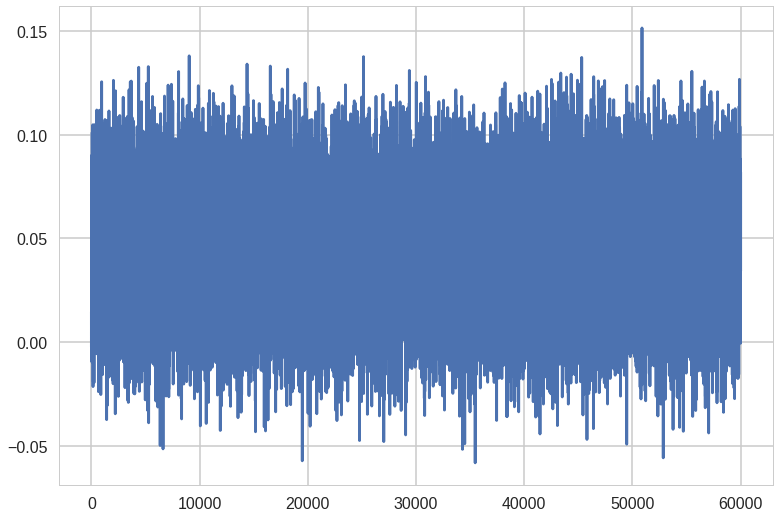

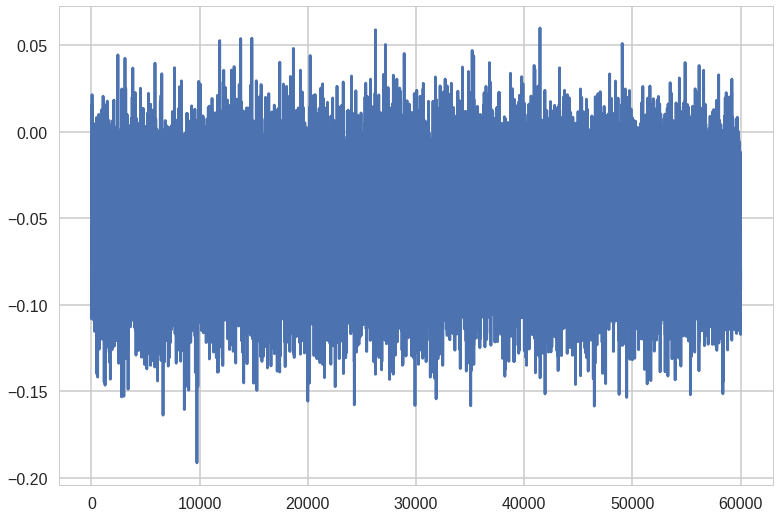

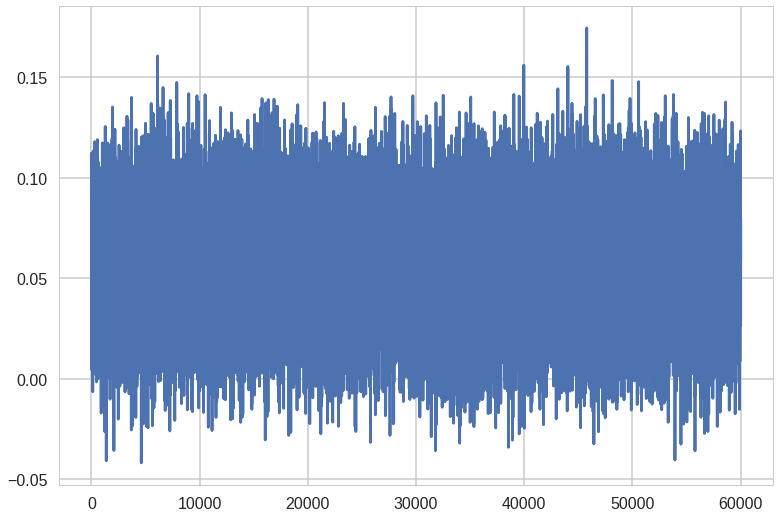

In [157]:
results = []

for hemisphere in ['R']:
    hddm_model = get_model('final_super_model_startpoint_group', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['z_cue_coding:STh_{hemisphere}_{segment}_cue'.format(**locals())],
                          'segment':segment,
                          'hemisphere':hemisphere})
        
        results.append(tmp)
        
        plt.figure()
        plt.plot(tmp['value'])

In [126]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'segment']).apply(lambda x: (x.value > 0).mean())


hemisphere  segment
R           A          0.964467
            B          0.021783
            C          0.985450
dtype: float64

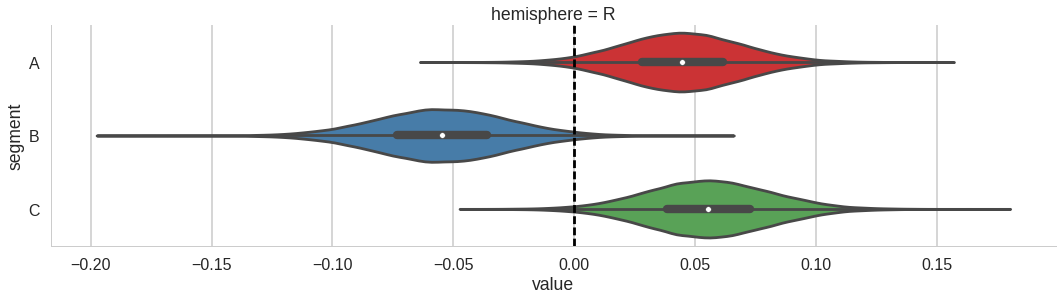

In [127]:
fac = sns.FacetGrid(df, col='hemisphere')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')


fac.fig.set_size_inches(25, 6)

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')

# Drift

In [128]:
results = []

for hemisphere in ['R']:
    hddm_model = get_model('final_super_model_drift', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())],
                          'segment':segment,
                          'hemisphere':hemisphere, 
                          'difficulty':'easy'})
        
        results.append(tmp)
        
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())] + traces['v_C(difficulty)[T.hard]:STh_{hemisphere}_{segment}_stim'.format(**locals())],
                  'segment':segment,
                  'hemisphere':hemisphere, 
                  'difficulty':'hard'})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_A_stim', 'v_C(difficulty)[T.hard]:STh_R_A_stim', 'v_STh_R_B_stim', 'v_C(difficulty)[T.hard]:STh_R_B_stim', 'v_STh_R_C_stim', 'v_C(difficulty)[T.hard]:STh_R_C_stim', 'v_cue_coding']


In [129]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'segment', 'difficulty']).apply(lambda x: (x.value > 0).mean())


hemisphere  segment  difficulty
R           A        easy          0.061617
                     hard          0.867250
            B        easy          0.922867
                     hard          0.539400
            C        easy          0.790600
                     hard          0.763133
dtype: float64

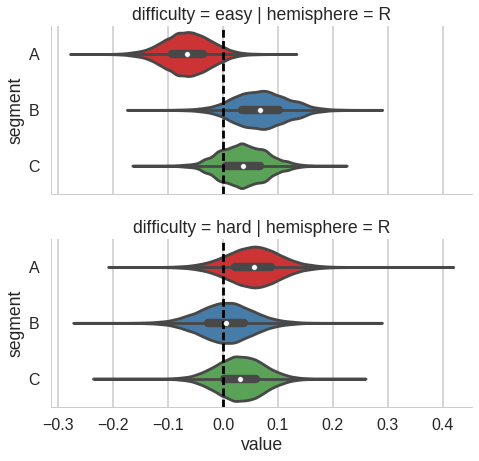

In [130]:
fac = sns.FacetGrid(df, col='hemisphere', row='difficulty')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')


fac.fig.set_size_inches(35, 7)

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')

# Drift group model

In [159]:
results = []

for hemisphere in ['R']:
    hddm_model = get_model('final_super_model_drift_group', hemisphere)
    
    traces = hddm_model.get_traces()
    
    for segment in ['A', 'B', 'C']:
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())],
                          'sample':traces.index,
                          'segment':segment,
                          'hemisphere':hemisphere, 
                          'difficulty':'easy'})
        
        results.append(tmp)
        
        tmp = pandas.DataFrame({'value':traces['v_STh_{hemisphere}_{segment}_stim'.format(**locals())] + traces['v_C(difficulty)[T.hard]:STh_{hemisphere}_{segment}_stim'.format(**locals())],
                  'segment':segment,
                   'sample':traces.index,                                
                  'hemisphere':hemisphere, 
                  'difficulty':'hard'})
        
        results.append(tmp)

Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_STh_R_A_stim', 'v_C(difficulty)[T.hard]:STh_R_A_stim', 'v_STh_R_B_stim', 'v_C(difficulty)[T.hard]:STh_R_B_stim', 'v_STh_R_C_stim', 'v_C(difficulty)[T.hard]:STh_R_C_stim', 'v_cue_coding']


In [160]:
df = pandas.concat(results, ignore_index=True)
df.groupby(['hemisphere', 'difficulty', 'segment']).apply(lambda x: (x.value > 0).mean())


hemisphere  difficulty  segment
R           easy        A          0.033367
                        B          0.961850
                        C          0.764500
            hard        A          0.952850
                        B          0.475483
                        C          0.645983
dtype: float64

In [161]:
tmp = df.pivot_table(index='sample', columns=['difficulty', 'segment'], values='value')

((tmp['easy', 'A'] - tmp['easy', 'B']) > 0).mean()

0.010133333333333333

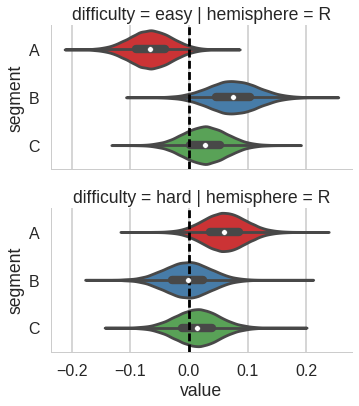

In [151]:
fac = sns.FacetGrid(df, col='hemisphere', row='difficulty')
fac.map(sns.violinplot, 'value', 'segment', palette='Set1')


fac.fig.set_size_inches(25, 6)

for ax in fac.axes.ravel():
    ax.axvline(0, c='k', ls='--')

(-0.1, 0.1)

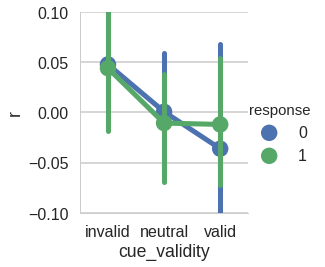

In [196]:
mask = 'STh_R_A_stim'
tmp = hddm_model.data.groupby(['subj_idx', 'cue_validity', 'response'], as_index=False).apply(lambda d: sp.stats.pearsonr(np.abs(d['rt']), d[mask])[0])

sns.factorplot('cue_validity', 'r', 'response', tmp.to_frame('r').reset_index())
plt.ylim(-.1, .1)

(-0.1, 0.1)

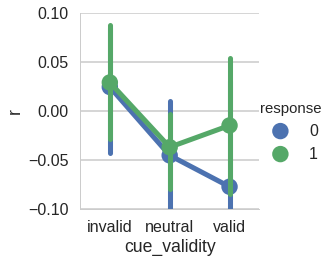

In [195]:
mask = 'STh_R_A_cue'
tmp = hddm_model.data.groupby(['subj_idx', 'cue_validity', 'response'], as_index=False).apply(lambda d: sp.stats.pearsonr(np.abs(d['rt']), d[mask])[0])

sns.factorplot('cue_validity', 'r', 'response', tmp.to_frame('r').reset_index())
plt.ylim(-.1, .1)

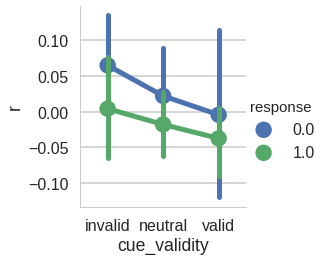

In [223]:
mask = 'STh_R_C_stim'
tmp = hddm_model.data.groupby(['subj_idx', 'cue_validity', 'response'], as_index=False).apply(lambda d: sp.stats.pearsonr(np.abs(d['rt']), d[mask])[0])

sns.factorplot('cue_validity', 'r', 'response', tmp.to_frame('r').reset_index())
# plt.ylim(-.1, .1)

(-0.1, 0.1)

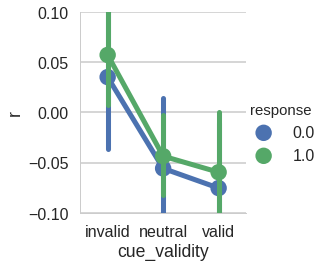

In [214]:
mask = 'STh_R_C_cue_resid'
tmp = hddm_model.data.groupby(['subj_idx', 'cue_validity', 'response'], as_index=False).apply(lambda d: sp.stats.pearsonr(np.abs(d['rt']), d[mask])[0])

sns.factorplot('cue_validity', 'r', 'response', tmp.to_frame('r').reset_index())
plt.ylim(-.1, .1)

In [200]:
import statsmodels.api as sm

In [213]:
for (subj_idx, run), d in hddm_model.data.groupby(['subject_id', 'run']):
    r = sm.OLS(d['STh_R_C_cue'], d['STh_R_C_stim']).fit().resid
    
    hddm_model.data.ix[d.index, 'STh_R_C_cue_resid'] = r

In [ ]:
hddm_model.data

In [211]:
hddm_model.data.groupby(['subject_id', 'run']).apply(lambda d: sp.stats.pearsonr(d['STh_R_A_cue_resid'], d['STh_R_A_stim'])[0])

subject_id  run
1.0         1.0    0.012370
            2.0    0.027794
            3.0   -0.000617
2.0         1.0    0.118476
            2.0    0.134238
            3.0    0.065762
3.0         1.0    0.003392
            2.0    0.065047
            3.0    0.036154
4.0         1.0    0.178094
            2.0    0.059247
            3.0    0.060995
5.0         1.0   -0.015693
            2.0    0.013022
            3.0   -0.000618
6.0         1.0    0.064662
            2.0    0.029419
7.0         1.0   -0.011616
            2.0    0.058679
            3.0    0.056776
8.0         1.0    0.045478
            2.0   -0.019141
            3.0    0.010267
9.0         1.0   -0.005435
            2.0    0.042087
            3.0    0.023182
10.0        1.0    0.035681
            2.0   -0.054467
            3.0    0.042079
11.0        1.0    0.030054
            2.0   -0.008092
            3.0    0.027198
12.0        1.0    0.050397
            2.0   -0.003567
            3.0    0.078654
13.0